# Workflow

## Libs

In [1]:
import os
import re

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from tqdm.auto import tqdm

# My modules
import parsing
import posing
import plotting
import feature_extraction

## Feature Extraction

In [2]:
subject_path = '../data/subjects_small'

pkls = []

for path, dirs, files in os.walk(subject_path):
    pkls += [os.path.join(path, f) for f in files if f.endswith('.pkl')]

print(f'# pickle files: {len(pkls)}')
pkl_head = '\n'.join(pkls[:10])
print(f"First ten pickle files:\n{pkl_head}")

# pickle files: 28
First ten pickle files:
../data/subjects_small\01\01_01.pkl
../data/subjects_small\01\01_02.pkl
../data/subjects_small\01\01_03.pkl
../data/subjects_small\01\01_04.pkl
../data/subjects_small\01\01_05.pkl
../data/subjects_small\01\01_06.pkl
../data/subjects_small\01\01_07.pkl
../data/subjects_small\01\01_08.pkl
../data/subjects_small\01\01_09.pkl
../data/subjects_small\01\01_10.pkl


In [3]:
feature_df = pd.DataFrame()
for pkl in tqdm(pkls):
    df = pd.read_pickle(pkl)
    features = feature_extraction.extract_features(df)
    features.index = [os.path.basename(pkl).replace('.pkl', '')]
    feature_df = pd.concat([feature_df, features])

feature_df

  0%|          | 0/28 [00:00<?, ?it/s]

,Torso Verticality Mean,Torso Verticality Std.,Instability,Hand Energy,Foot Energy,Head Energy
01_01,0.943458,0.083070,2.229913,0.216813,0.181132,0.052448
01_02,0.742631,0.220370,8.050832,0.182885,0.219635,0.044672
01_03,0.796605,0.211797,10.380910,0.240885,0.220518,0.061694
01_04,0.929846,0.073017,4.009411,0.147043,0.181545,0.033167
01_05,0.793071,0.227410,4.248218,0.213413,0.217981,0.049893
01_06,0.901182,0.132773,3.994250,0.155356,0.211207,0.033975
01_07,0.885631,0.153798,6.169081,0.203210,0.236872,0.048106
01_08,0.882973,0.165648,8.407590,0.233869,0.221303,0.058143
01_09,0.864001,0.169901,8.477148,0.224604,0.251490,0.056686
01_10,0.888731,0.107535,5.603204,0.254969,0.244055,0.060752


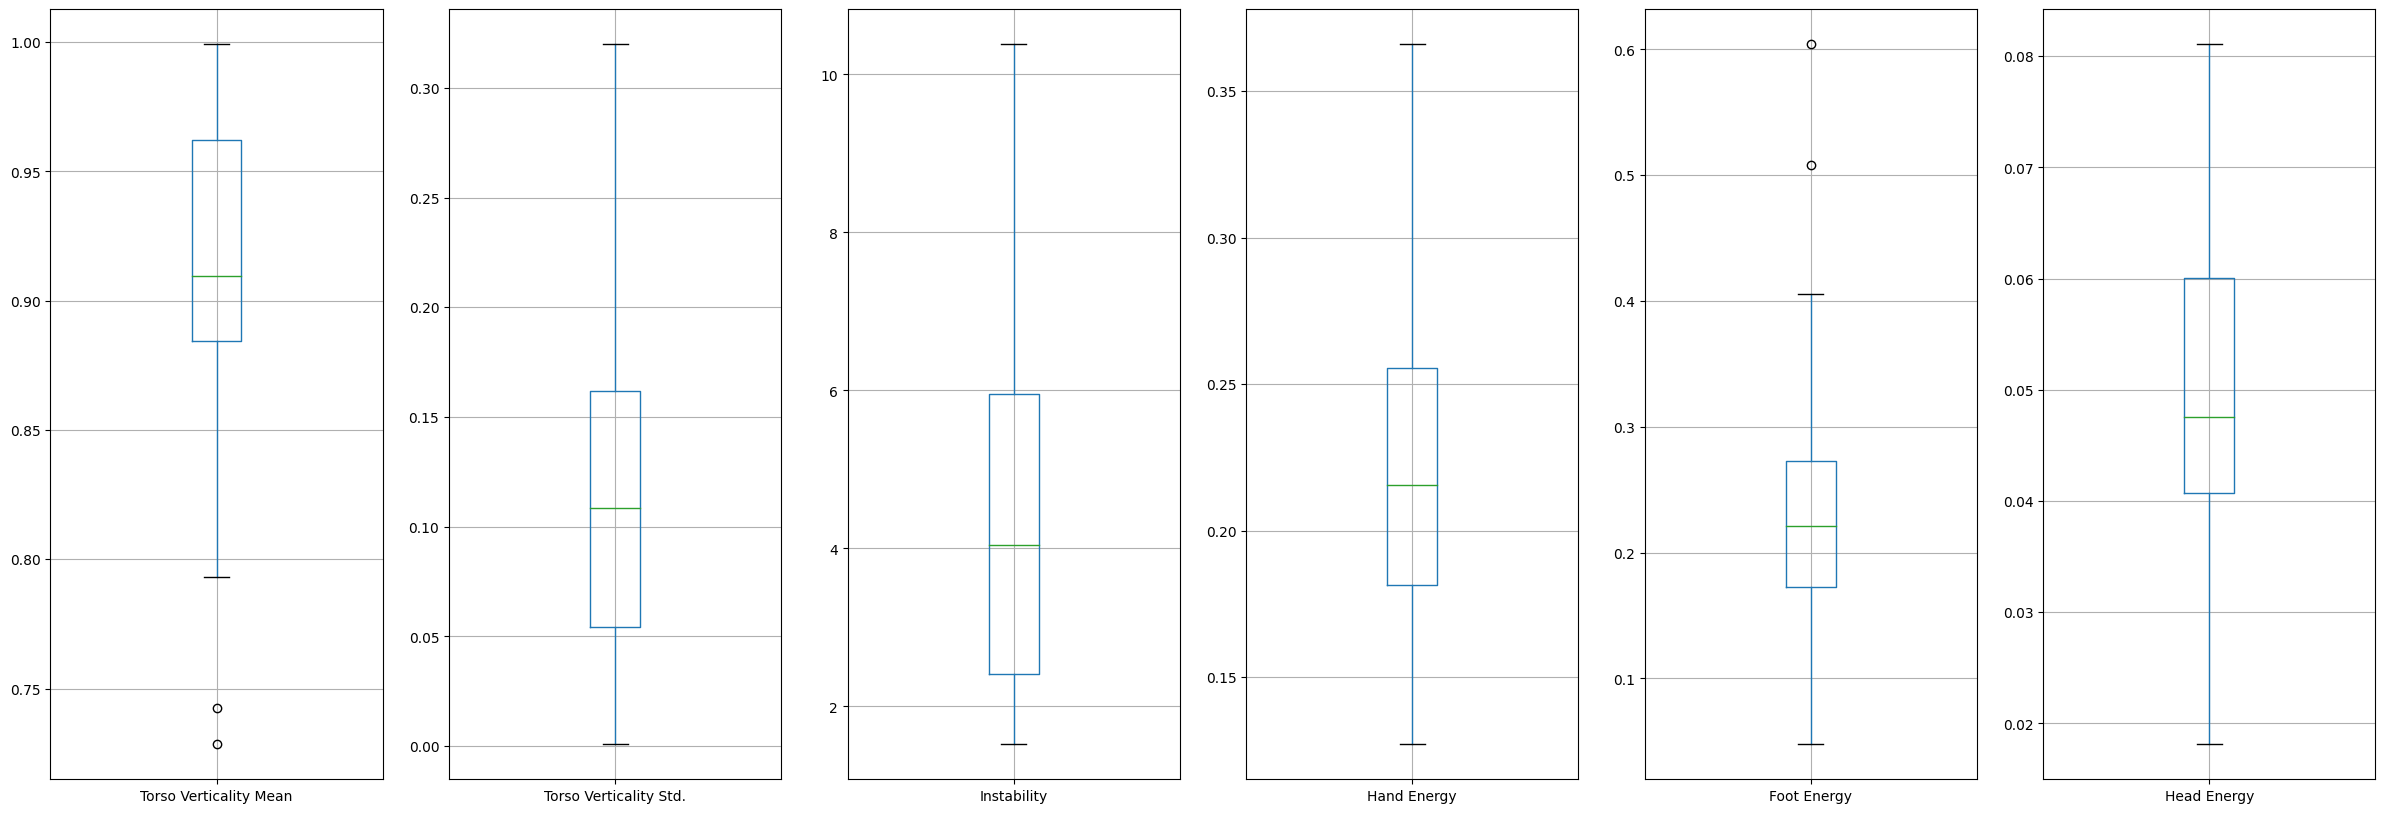

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(feature_df.columns), figsize=(30, 10))

for i, col in enumerate(feature_df.columns):
    feature_df.boxplot(col, ax=ax[i])

In [5]:
display(feature_df.corr())
px.imshow(feature_df.corr())

,Torso Verticality Mean,Torso Verticality Std.,Instability,Hand Energy,Foot Energy,Head Energy
Torso Verticality Mean,1.000000,-0.939461,-0.179308,0.190789,0.472004,-0.499854
Torso Verticality Std.,-0.939461,1.000000,0.006942,-0.172404,-0.566613,0.533551
Instability,-0.179308,0.006942,1.000000,-0.232703,0.219031,-0.048627
Hand Energy,0.190789,-0.172404,-0.232703,1.000000,0.354200,0.275314
Foot Energy,0.472004,-0.566613,0.219031,0.354200,1.000000,-0.343434
Head Energy,-0.499854,0.533551,-0.048627,0.275314,-0.343434,1.000000


In [6]:
print(feature_df.corr().to_markdown())

|                        |   Torso Verticality Mean |   Torso Verticality Std. |   Instability |   Hand Energy |   Foot Energy |   Head Energy |
|:-----------------------|-------------------------:|-------------------------:|--------------:|--------------:|--------------:|--------------:|
| Torso Verticality Mean |                 1        |              -0.939461   |   -0.179308   |      0.190789 |      0.472004 |    -0.499854  |
| Torso Verticality Std. |                -0.939461 |               1          |    0.00694171 |     -0.172404 |     -0.566613 |     0.533551  |
| Instability            |                -0.179308 |               0.00694171 |    1          |     -0.232703 |      0.219031 |    -0.0486273 |
| Hand Energy            |                 0.190789 |              -0.172404   |   -0.232703   |      1        |      0.3542   |     0.275314  |
| Foot Energy            |                 0.472004 |              -0.566613   |    0.219031   |      0.3542   |      1        |  

## Feature Selection

In [7]:
feature_df1 = feature_df[['Torso Verticality Std.', 'Instability']]

cuts = {
    col + ' Cut': pd.qcut(feature_df1[col], 2, labels=['Lo ' + col, 'Hi ' + col])
    for col in feature_df1.columns
}

d1 = feature_df.assign(**cuts)
d1['bin'] = pd.Categorical(d1.filter(regex='Cut').apply(tuple, 1))

print(list(d1.filter(regex='Cut').columns))
d1['bin'].value_counts()

['Torso Verticality Std. Cut', 'Instability Cut']


bin
(Hi Torso Verticality Std., Hi Instability)    7
(Hi Torso Verticality Std., Lo Instability)    7
(Lo Torso Verticality Std., Hi Instability)    7
(Lo Torso Verticality Std., Lo Instability)    7
Name: count, dtype: int64